# Model description (deep learning)
packages used: tensorflow, keras, wandb  
Hardware: NVIDIA RTX 3060 Ti (local)  

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data

In [2]:
# define column sets
feature_columns = {
    "market" : ['volume_eth', 'price_p5_eth_lag1', 'price_max_eth_lag1', 'price_min_eth_lag1'],
    "traits_rarity" : ['rarity_rank', 'Background_count', 'Mouth_count', 'Eyes_count', 'Fur_count', 'Hat_count', 'Clothes_count', 'Earring_count'],
    "last_trade" : ['last_trade_timediff', 'last_trade_price'],
}

outcome_columns = {
    'trade_price' : 'trade_price',
    'amount_usd' : 'amount_usd',
    'trade_price_log' : 'trade_price_log'
}

In [3]:
X_cols = feature_columns['market'] + feature_columns['traits_rarity'] + feature_columns['last_trade']
y_col = "trade_price"

In [4]:
data = pd.read_csv("data/bayc_cleaned.csv")

data = data.dropna(subset=X_cols+[y_col])
X = data[X_cols]
y = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# resize for CNN
X_train = np.expand_dims(X_train, axis=2)

# Build keras model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import keras_tuner


def build_model(hp):
    """
    Build a CNN model for predicting trade price of NFTs
    hp: HyperParameters object from keras_tuner
    Tunable hyperparameters:
        filters: Int
        kernel_size: Int
        units: Int Choice [64, 128, 256, 512]
        dropout: Boolean
        learning_rate: Float Choice [1e-2, 1e-3, 1e-4]
    """

    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(X_train.shape[1],1)))
    
    # Conv1D layer
    model.add(Conv1D(
        filters=hp.Int("filters", min_value=32, max_value=256, step=32),
        kernel_size=hp.Int("kernel_size", min_value=2, max_value=5, step=1), 
        activation='relu'
        ))
    
    # MaxPooling layer
    model.add(MaxPooling1D(pool_size=2))
    
    # Flatten layer
    model.add(Flatten())
    
    # Dense layers    
    model.add(Dense(
        units=hp.Choice('units', values=[64, 128, 256, 512]),
        activation='relu'
        ))
    
    model.add(Dense(
        units=32, 
        activation='relu'
        ))
    
    # Dropout layer
    if hp.Boolean("dropout"):
        model.add(Dropout(0.25))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        )
    
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error'
        )
    
    return model

# Integrate with weights & biases

In [6]:
import wandb
from wandb.keras import WandbCallback

In [7]:
# login weights & biases (requires .env or CLI login)
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mingxuan-he. Use `wandb login --relogin` to force relogin


True

In [8]:

# # not used

# class MyTuner(keras_tuner.RandomSearch):
#     """
#     Custom tuner class for displaying keras_tuner progress in wandb
#     """
    
#     def run_trial(self, trial, X, y, batch_size, epochs, objective):
#         """
#         modify run_trial method to display progress in wandb
#         """
        
#         hp = trial.hyperparameters
        
#         model = self.hypermodel.build(hp)
        
#         # initialize wandb run
#         run = wandb.init(
#             project="bayc",
#             entity="mingxuan-he",
#             config=hp.values
#         )
        
#         history = model.fit(
#             X, y,
#             batch_size=batch_size,
#             epochs=epochs,
#             validation_split=0.2,
#             callbacks=[WandbCallback()]
#         )
        
#         val_loss = history.history['val_loss'][-1]
        
#         self.oracle.update_trial(trial.trial_id, {objective:val_loss})
        
#         run.finish()
    
#     # def save_model(self, trial_id, model, step=0):
#     #     """Save a model for a given trial."""
#     #     fname = f'model_{trial_id}.h5'
#     #     model_dir = os.path.join(self.get_trial_dir(trial_id), 'model')
#     #     if not os.path.exists(model_dir):
#     #         os.makedirs(model_dir)
#     #     model_path = os.path.join(model_dir, fname)
#     #     model.save(model_path)
        
        

## Create custom HyperModel class for integration with w&b

In [9]:
class MyHyperModel(keras_tuner.HyperModel):
    
    """ 
    Custom hypermodel class for keras_tuner, with integrated wandb logging
    """
    
    def build(self, hp):
        
        run = wandb.init(
            project="NFT_Pred",
            entity="mingxuan-he",
            config=hp.values
        )
        
        model = build_model(hp)
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        
        if 'callbacks' in kwargs:
            kwargs['callbacks'].append(WandbCallback())
        else:
            kwargs['callbacks'] = [WandbCallback()]
        
        history = model.fit(
            *args,
            **kwargs,
        )
        
        wandb.finish()
        
        return history

# Model training with hyperparam tuning

In [10]:
# instantiate RandomSearch tuner
tuner = keras_tuner.tuners.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='./tuner',
    project_name='NFT_Pred'
)

In [11]:
# search space for hyperparameters
tuner.search_space_summary()

Search space summary
Default search space size: 5
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256, 512], 'ordered': True}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [12]:
# main training function
tuner.search(
    X_train,
    y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_test, y_test),
)

Trial 14 Complete [00h 00m 24s]

Best val_loss So Far: 216.9014892578125
Total elapsed time: 00h 26m 06s

Search: Running Trial #15

Value             |Best Value So Far |Hyperparameter
32                |64                |filters
2                 |5                 |kernel_size
64                |512               |units
True              |True              |dropout
0.0001            |0.001             |learning_rate



Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\wandb\sdk\wandb_init.py", line 1166, in init
    run = wi.init()
  File "c:\ProgramData\Anaconda3\lib\site-packages\wandb\sdk\wandb_init.py", line 599, in init
    latest_run.finish()
  File "c:\ProgramData\Anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 420, in wrapper
    return func(self, *args, **kwargs)
  File "c:\ProgramData\Anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 361, in wrapper
    return func(self, *args, **kwargs)
  File "c:\ProgramData\Anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 1953, in finish
    return self._finish(exit_code, quiet)
  File "c:\ProgramData\Anaconda3\lib\site-packages\wandb\sdk\wandb_run.py", line 1961, in _finish
    tel.feature.finish = True
  File "c:\ProgramData\Anaconda3\lib\site-packages\wandb\sdk\lib\telemetry.py", line 42, in __exit__
    self._run._telemetry_callback(self._obj)
  File "c:\ProgramData\Anaconda3\lib\site-pac

: 

# Results

In [12]:
# get best model & hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("best hyperparameters:")
print(best_hps.values)
print("best model architecture:")
print(best_model.summary())
wandb.finish() # end wandb run initiated by get_best_models

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [12]:
predictions = best_model.predict(X_test)

215/215 [==============================] - 0s 907us/step


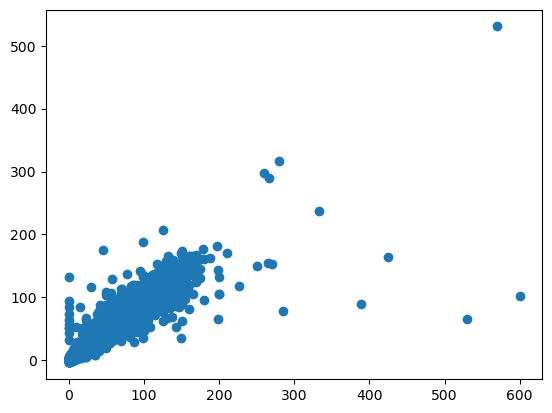

In [13]:
import matplotlib.pyplot as plt
plt.scatter(y_test, predictions)
plt.show()

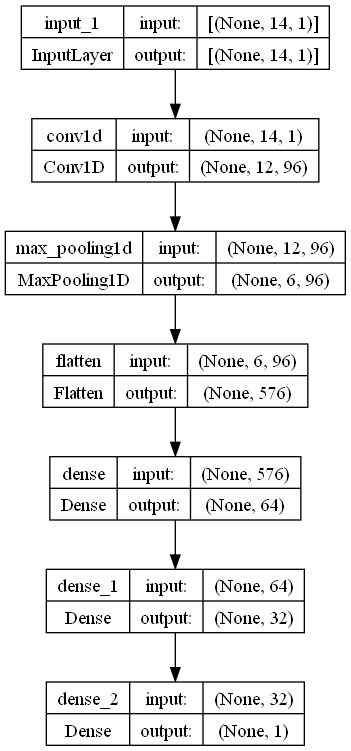

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(best_model, show_shapes=True, show_layer_names=True)

In [15]:
from keras_visualizer import visualizer
visualizer(best_model, file_name="figures/nn", file_format='png', view=True)